In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from bib.cleaning import *
from bib.plot import *
import math

In [3]:
contatos01 = pd.read_excel('./dados/last.xlsx',sheet_name='Contatos_01')
contatos02 = pd.read_excel('./dados/last.xlsx',sheet_name='Contatos_02')
data = pd.read_excel('./dados/last.xlsx',sheet_name='Pessoas')
Nmortos = generate_mortalidade()
Faixa = [
    [0,20],
    [20,30],
    [30,50],
    [50,70],
    [70,10000]
]
tempo = [2.5, 7.5,22.5,120,240]

In [7]:
degree = (data['#Contatos01'].values + data['#Contatos02'].values)/2
degree = np.ceil(degree).astype(int)

In [4]:
def transform_faixa(i,Faixa):
    for j in range(len(Faixa)):
        if(i < Faixa[j][0]):
            return j - 1
    return j

In [5]:
Idade = data['Idade'].values
Idade = np.array([transform_faixa(i,Faixa) for i in Idade])
data['Faixa'] = Idade

Idade = contatos01['idade'].values
Idade = np.array([transform_faixa(i,Faixa) for i in Idade])
contatos01['Faixa'] = Idade

Idade = contatos02['idade'].values
Idade = np.array([transform_faixa(i,Faixa) for i in Idade])
contatos02['Faixa'] = Idade

In [8]:
faixa = data['Faixa'].values[degree > 0]
np.savetxt('./C/dados/faixas.txt',faixa,fmt = '%d')

In [6]:
Idades = list(data['Idade'].values) + list(contatos01['idade'].values) + list(contatos02['idade'].values)

In [10]:
Idades = [i for i in Idades if(not math.isnan(i))]

In [32]:
y,x = np.histogram(np.array(Idades),bins = 20)

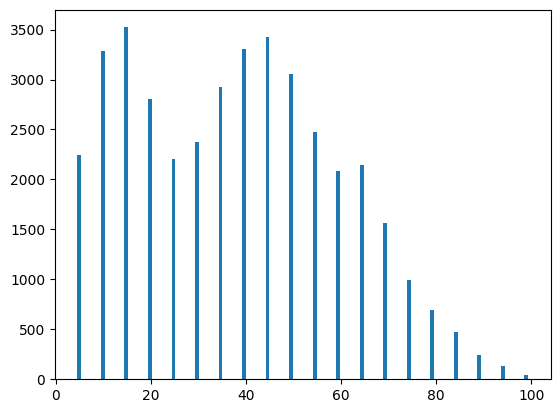

In [35]:
plt.bar(x[1:],y)
plt.show()

In [33]:
x

array([ 0.  ,  4.95,  9.9 , 14.85, 19.8 , 24.75, 29.7 , 34.65, 39.6 ,
       44.55, 49.5 , 54.45, 59.4 , 64.35, 69.3 , 74.25, 79.2 , 84.15,
       89.1 , 94.05, 99.  ])

In [12]:
df = {i:[0]*5 for i in range(2033)}
df2 = {i:[0]*5 for i in range(2033)}

In [13]:
for i in data['id']:
    faixas = contatos01[contatos01['id'] == i]['Faixa'].values
    for faixa in faixas:
        df[i][faixa] += 1
for i in data['id']:
    faixas = contatos02[contatos02['id'] == i]['Faixa'].values
    for faixa in faixas:
        df2[i][faixa] += 1

In [14]:
a = []
for i in df:
    a.append(df[i])
a = np.array(a)
b = []
for i in df:
    b.append(df[i])

b = np.array(b)
a = (a+b)/2
a = np.ceil(a).astype(int)
soma = np.argsort(np.sum(a,axis = 1))[::-1]
a = a[soma]
Faixas = data['Faixa'].values[soma]
Faixas = Faixas[~np.all(a == 0, axis=1)]
a = a[~np.all(a == 0, axis=1)]


In [6]:
np.unique(data['Faixa'],return_counts = True)

(array([0, 1, 2, 3, 4]), array([858, 169, 231, 549, 226]))

In [18]:
np.savetxt('./C/degrees.txt',a,fmt = "%d",delimiter='\t')

In [20]:
np.savetxt('./C/faixas.txt',Faixas,fmt = "%d")

In [9]:
def generate_gij(data,contatos01):
    id_ = data['id'].values
    faixas = data['Faixa'].values
    g_ij = np.zeros((5,5))
    for i,faixa in zip(id_,faixas):
        for j in contatos01[contatos01['id'] == i]['Faixa'].values:
            #print(i,j)
            g_ij[faixa][j] += 1
            #g_ij[j][faixa] += 1
    return g_ij

In [10]:
g_ij01 = generate_gij(data,contatos01)
g_ij02 = generate_gij(data,contatos02)

In [13]:
def generate_triangular(g_ij01):
    for i in range(len(g_ij01)):
        for j in range(len(g_ij01)):
            if(i<j):
                g_ij01[i][j] += g_ij01[j][i]
                g_ij01[i][j] = g_ij01[i][j]/2
            if(i == j):
                g_ij01[i][j] = g_ij01[i][j]/2
    for i in range(len(g_ij01)):
        for j in range(len(g_ij01)):
            if(i>j):
                g_ij01[i][j] = 0
    return g_ij01

In [22]:
g_ij01

array([[2166.5,  461. , 1550.5,  711. ,  161. ],
       [   0. ,  333.5,  466.5,  385. ,   96. ],
       [   0. ,    0. ,  564.5, 1127.5,  311.5],
       [   0. ,    0. ,    0. ,  895. ,  495.5],
       [   0. ,    0. ,    0. ,    0. ,  197. ]])

In [14]:
g_ij01 = generate_triangular(g_ij01)
g_ij02 = generate_triangular(g_ij02)

In [25]:
np.sum(g_ij01)

9922.0

In [18]:
np.sum(degree)/2

9864.0

In [23]:
g_ij = np.ceil((np.ceil(g_ij01)+np.ceil(g_ij02))*0.5)

In [24]:
np.sum(g_ij)

9501.0

In [129]:
def generate_tij(data,contatos01,tempo):
    id_ = data['id'].values
    faixas = data['Faixa'].values
    t_ij = np.zeros((5,5))
    sigma_ij = np.zeros((5,5))
    for i,faixa in zip(id_,faixas):
        df = contatos01[contatos01['id'] == i]
        for j,t in zip(df['Faixa'].values,df['Duração'].values):
            #print(i,j)
            if(not math.isnan(t)):
                t_ij[faixa][j] += tempo[int(t)-1]
                t_ij[j][faixa] += tempo[int(t)-1]
                sigma_ij[faixa][j] += tempo[int(t)-1]**2
                sigma_ij[j][faixa] += tempo[int(t)-1]**2
    return t_ij,sigma_ij

In [140]:
t_ij,sigma_ij = generate_tij(data,contatos01,tempo)

In [141]:
t_ij/p_i,sigma_ij

(array([[1122.62237762,  500.0443787 , 1469.15584416,  231.17941712,
          121.68141593],
        [  98.49358974,  775.35502959,  231.51515152,   74.90892532,
           45.21017699],
        [ 395.54195804,  316.44970414,  500.23809524,  167.21311475,
           87.95353982],
        [ 147.92249417,  243.34319527,  397.4025974 ,  455.29143898,
          248.3960177 ],
        [  32.05128205,   60.45857988,   86.04978355,  102.25409836,
          305.28761062]]),
 array([[1.89702225e+08, 1.58491812e+07, 6.83958750e+07, 2.36347938e+07,
         5.06067500e+06],
        [1.58491812e+07, 2.49464125e+07, 9.39548750e+06, 6.77470000e+06,
         1.87204375e+06],
        [6.83958750e+07, 9.39548750e+06, 2.07414625e+07, 1.39932375e+07,
         2.76004375e+06],
        [2.36347938e+07, 6.77470000e+06, 1.39932375e+07, 4.48514875e+07,
         9.34891875e+06],
        [5.06067500e+06, 1.87204375e+06, 2.76004375e+06, 9.34891875e+06,
         1.33442125e+07]]))

In [69]:
Idade = data['Idade'].values
Idade = np.array([transform_faixa(i,Faixa) for i in Idade])
data['Faixa'] = Idade
_, p_i = np.unique(Idade,return_counts = True)

In [35]:
p_i = p_i/np.sum(p_i)

In [58]:
g_ij01 = (g_ij01+g_ij02)/2

In [59]:
g_ij01

array([[8824. ,  898.5, 2961.5, 1336. ,  321.5],
       [ 898.5, 1271. ,  865.5,  750.5,  167.5],
       [2961.5,  865.5, 2152. , 2099. ,  543.5],
       [1336. ,  750.5, 2099. , 3308. ,  913.5],
       [ 321.5,  167.5,  543.5,  913.5,  712. ]])

In [50]:
g_ij = np.zeros((len(g_ij01),len(g_ij01)))
for i in range(len(g_ij01)):
    g_ij[i][i:] = g_ij01[i][i:]/np.sum(g_ij01[i])

In [51]:
g_ij = g_ij/np.sum(g_ij)

In [52]:
W = np.maximum( g_ij, g_ij.transpose() )

In [ ]:
np.savetxt("./C/SBM/probability.txt",W, fmt='%f')

In [53]:
W = np.ceil((np.sum(degree)/2)*W)

In [54]:
np.sum(W)/(np.sum(degree)/2)

1.4047039740470397

In [26]:
np.savetxt("./C/dados/ligacoes.txt",g_ij, fmt='%d')

In [76]:
np.trace(g_ij02[0])/2,np.sum(degree)/2

ValueError: diag requires an array of at least two dimensions

In [80]:
np.sum(g_ij01,axis = 1)

array([14433.,  4151.,  9170.,  9018.,  2916.])

In [49]:
for i in range(len(g_ij)):
    g_ij[i] = g_ij[i]/np.sum(g_ij[i])

In [50]:
g_ij

array([[0.61527734, 0.06265035, 0.20649862, 0.09315622, 0.02241746],
       [0.22729572, 0.32152795, 0.21894763, 0.18985581, 0.04237288],
       [0.34350171, 0.10038856, 0.24960854, 0.24346111, 0.06304007],
       [0.15891519, 0.08927085, 0.24967289, 0.39348162, 0.10865945],
       [0.12095561, 0.06301731, 0.20447705, 0.34367946, 0.26787058]])

In [54]:
degree,data['Faixa'].values

(array([ 2,  5, 11, ..., 10,  9, 14]), array([2, 0, 0, ..., 1, 0, 0]))

In [57]:
a = np.ceil([degree[j]*g_ij[i] for i,j in zip(data['Faixa'].values,data['id'].values)])

In [61]:
np.ceil(a)[degree > 0]

array([[1., 1., 1., 1., 1.],
       [4., 1., 2., 1., 1.],
       [7., 1., 3., 2., 1.],
       ...,
       [3., 4., 3., 2., 1.],
       [6., 1., 2., 1., 1.],
       [9., 1., 3., 2., 1.]])

array([ 2,  5, 11, ..., 10,  9, 14])